#### Instructions

For questions 1, 2, and 3: 

- Use only the provided dataset
- Scale the features using StandardScaler() from sklearn.preprocessing
- Apply K-means clustering using KMeans() from sklearn.cluster with the following settings: 
    - Set init = 'random' (this will make it so that the initial centroids are randomly assigned)
    - Set random_state = 9001 (this will allow us to compare your results with our own)
    - Set n_init = 20 (as we are going for randomly assigned initial centroids, this will make it so that the algorithm runs twenty times with the best output in terms of inertial being displayed)
- Search for K in {2, 3, 4, 5, 6} 
    - For each K, fit the model on the scaled features and compute Inertia (WCSS) and Average silhouette score; you may use use silhouette_score() from sklearn.metrics to obtain this
- Elbow check: compute the drop in inertia for all K values and identify the largest drop across the tested values; this is the optimal K value using the elbow method
- For each K value, report the cluster counts (number of samples per cluster)
 
Questions 4 and 5 are conceptual theory-based questions and do not involve any coding. 

In [30]:
import warnings; warnings.filterwarnings('ignore')
import sys; import os; sys.stderr = open(os.devnull, 'w')
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns  # Data processing and visualisation
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.cluster import KMeans  # K-means clustering
from sklearn.metrics import silhouette_score  # Silhouette metric
from sklearn.manifold import TSNE  # To visualise clustering results


In [31]:
import yaml

# Load the environment.yml file
with open("../configs/environment.yml", "r") as f:
    config = yaml.safe_load(f)

# Choose environment (local or aws)
env = "local"   # or "aws"

raw_data_path = config[env]["base_path"] + config[env]["raw_data"]
processed_data_path = config[env]["base_path"] + config[env]["processed_data"]
models_path = config[env]["base_path"] + config[env]["models"]

print("Raw data path:", raw_data_path)
print("Processed data path:", processed_data_path)
print("Models path:", models_path)


Raw data path: /Users/aditikulkarni/Documents/Masters/AI-Projects/04-ML-Models/clustering/data/raw/
Processed data path: /Users/aditikulkarni/Documents/Masters/AI-Projects/04-ML-Models/clustering/data/processed/
Models path: /Users/aditikulkarni/Documents/Masters/AI-Projects/04-ML-Models/clustering/models/


In [32]:
# --- load data ---
df = pd.read_csv(raw_data_path + "carprices-truncated.csv")

print("Raw shape:", df.shape)
print("Missing values per column:\n", df.isnull().sum())

Raw shape: (205, 4)
Missing values per column:
 enginesize    0
horsepower    0
citympg       0
highwaympg    0
dtype: int64


In [33]:
df.head()

,enginesize,horsepower,citympg,highwaympg
0,130,111,21,27
1,130,111,21,27
2,152,154,19,26
3,109,102,24,30
4,136,115,18,22


In [34]:
# --- For assignment: use only provided dataset but ensure numeric features only ---
# (If the dataset is all numeric you can skip selection; this is safe.)
df = df.select_dtypes(include=[np.number]).copy()
print("Numeric shape:", df.shape)

# --- Handle missing values: drop rows with NaNs (or consider imputation if allowed) ---
if df.isnull().any().any():
    df = df.dropna().reset_index(drop=True)
    print("After dropping NaNs, numeric shape:", df.shape)

Numeric shape: (205, 4)


In [35]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
enginesize,205.0,126.907317,41.642693,61.0,97.0,120.0,141.0,326.0
horsepower,205.0,104.117073,39.544167,48.0,70.0,95.0,116.0,288.0
citympg,205.0,25.219512,6.542142,13.0,19.0,24.0,30.0,49.0
highwaympg,205.0,30.751220,6.886443,16.0,25.0,30.0,34.0,54.0


In [36]:
# --- Scale features ---
scaler = StandardScaler()
dfs = scaler.fit_transform(df)

In [37]:
dfs

array([[ 0.07444893,  0.17448278, -0.64655303, -0.54605874],
       [ 0.07444893,  0.17448278, -0.64655303, -0.54605874],
       [ 0.60404617,  1.26453643, -0.95301169, -0.69162706],
       [-0.43107572, -0.05366798, -0.18686504, -0.10935377],
       [ 0.21888454,  0.27588312, -1.10624102, -1.27390036],
       [ 0.21888454,  0.14913269, -0.95301169, -0.83719538],
       [ 0.21888454,  0.14913269, -0.95301169, -0.83719538],
       [ 0.21888454,  0.14913269, -0.95301169, -0.83719538],
       [ 0.09852153,  0.90963524, -1.25947035, -1.565037  ],
       [ 0.09852153,  1.41663694, -1.41269968, -1.27390036],
       [-0.45514832, -0.07901807, -0.34009437, -0.25492209],
       [-0.45514832, -0.07901807, -0.34009437, -0.25492209],
       [ 0.89291739,  0.42798363, -0.64655303, -0.40049041],
       [ 0.89291739,  0.42798363, -0.64655303, -0.40049041],
       [ 0.89291739,  0.42798363, -0.79978236, -0.83719538],
       [ 1.97618448,  1.9743388 , -1.41269968, -1.27390036],
       [ 1.97618448,  1.

In [38]:
dfs.shape

(205, 4)

```elbow_k selection```: 
Pick the K after the largest inertia drop (i.e., the value of K that resulted in the biggest improvement when added). This is consistent with “the largest drop across the tested values” interpretation. If your instructor expects the K before the drop, change to K_values[idx_max_drop] and explain which convention you used. Be explicit in the assignment text.

inertia_arr = np.array([385, 234, 174, 133, 111])

| Slice              | Meaning                           | Result for this example |
| :----------------- | :-------------------------------- | :---------------------- |
| `inertia_arr[:-1]` | All elements **except the last**  | `[385, 234, 174, 133]`  |
| `inertia_arr[1:]`  | All elements **except the first** | `[234, 174, 133, 111]`  |


K=2  Inertia=385.230909  Silhouette=0.470819
   Cluster counts: {0: 85, 1: 120}
K=3  Inertia=234.453666  Silhouette=0.453655
   Cluster counts: {0: 61, 1: 98, 2: 46}
K=4  Inertia=174.141190  Silhouette=0.433666
   Cluster counts: {0: 15, 1: 41, 2: 88, 3: 61}
K=5  Inertia=133.708340  Silhouette=0.420071
   Cluster counts: {0: 15, 1: 52, 2: 41, 3: 80, 4: 17}
K=6  Inertia=111.621291  Silhouette=0.414808
   Cluster counts: {0: 15, 1: 46, 2: 63, 3: 17, 4: 33, 5: 31}
Drop from K=2 -> K=3 : 150.777243
Drop from K=3 -> K=4 : 60.312476
Drop from K=4 -> K=5 : 40.432850
Drop from K=5 -> K=6 : 22.087048

Elbow method chooses K = 3 (largest drop from K=2 -> K=3)


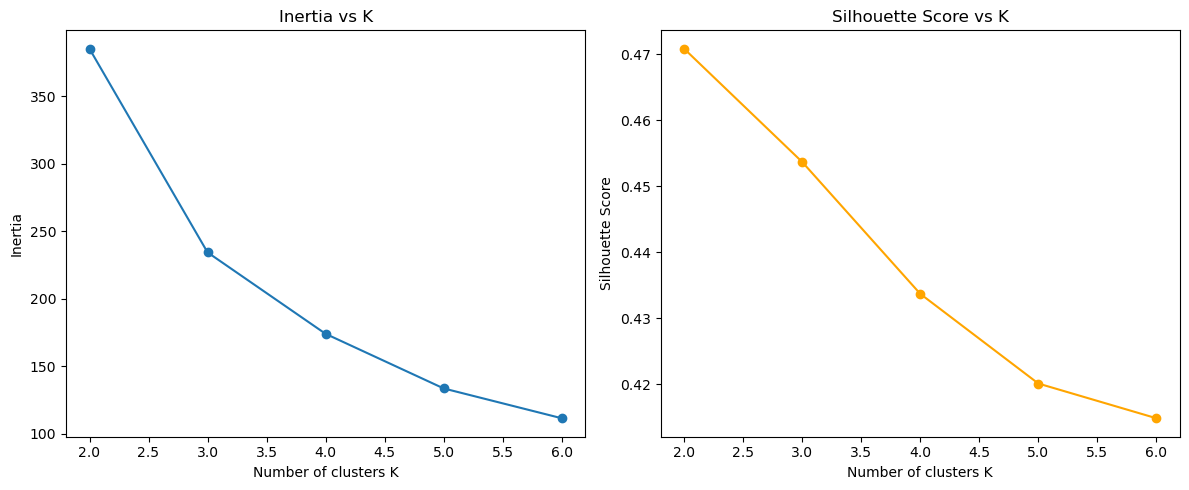

In [45]:
# --- K search per assignment ---
inertia_list = []
silhouette_list = []
cluster_counts_dict = {}
K_values = [2, 3, 4, 5, 6]

for k in K_values: # K= 2,3,4,5,6
    kmeans_model = KMeans(n_clusters=k, init='random', n_init=20, random_state=9001)
    kmeans_model.fit(dfs)
    inertia = kmeans_model.inertia_
    silhouette = silhouette_score(dfs, kmeans_model.labels_)
    inertia_list.append(inertia)
    silhouette_list.append(silhouette)

    # Report the number of data points in each cluster
    unique, counts = np.unique(kmeans_model.labels_, return_counts=True)

    # convert numpy int types to python int (clean printing)
    cluster_counts = {int(u): int(c) for u, c in zip(unique, counts)}
    cluster_counts_dict[k] = cluster_counts

    print(f"K={k:>1}  Inertia={inertia:.6f}  Silhouette={silhouette:.6f}")
    print(f"   Cluster counts: {cluster_counts}")

# --- Elbow check: compute drops and choose K ---
# drop_i corresponds to improvement from K_values[i] -> K_values[i+1]
inertia_arr = np.array(inertia_list)
drops = inertia_arr[:-1] - inertia_arr[1:]   # positive values (how much inertia decreased)
for i, d in enumerate(drops):
    print(f"Drop from K={K_values[i]} -> K={K_values[i+1]} : {d:.6f}")

# Choose K as the K after the largest drop (i.e., the K that produced the largest improvement)
idx_max_drop = np.argmax(drops)
elbow_k = K_values[idx_max_drop + 1]
print(f"\nElbow method chooses K = {elbow_k} (largest drop from K={K_values[idx_max_drop]} -> K={elbow_k})")


# Plot inertia vs K
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_values, inertia_list, marker='o')
plt.title('Inertia vs K')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
# Plot silhouette vs K
plt.subplot(1, 2, 2)
plt.plot(K_values, silhouette_list, marker='o', color='orange')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters K')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

1️⃣ Inertia
- Drops steeply from 385 → 234 → 174, then flattens after K=4.
- 👉 Suggests elbow near K = 3 or 4.

2️⃣ Silhouette
- Highest at K=2 (0.47), then decreases up to K=7.
- Slightly improves again at K=8 (0.43) and K=9 (0.45), but not higher than K=2.

| **K** | **Inertia Drop (Δ)** | **Comment**                        |
| :---: | :------------------: | :--------------------------------- |
| 2 → 3 |      Large drop      | Good improvement                   |
| 3 → 4 |     Moderate drop    | Still improving                    |
| 4 → 5 |     Smaller drop     | Diminishing returns                |
|   >5  |      Very small      | Plateau — not worth extra clusters |

✅ Elbow appears around K = 3 or 4

But:
- Silhouette is highest for K=2 (0.47) → strongest separation.
- For K>2, Silhouette gradually decreases (clusters start overlapping).

So we trade off:
- K=2 → very clean, large clusters (high separation)
- K=3–4 → better fit (lower inertia) but slightly lower silhouette

| **If your goal is:**                                          | **Best K**   | **Reason**                                              |
| :------------------------------------------------------------ | :----------- | :------------------------------------------------------ |
| **Simplest, well-separated clustering**                       | **K = 2** ✅  | Highest silhouette (0.47), clear separation             |
| **Balanced elbow trade-off (compactness + interpretability)** | **K = 3** 👍 | Big inertia drop from 2→3, reasonable silhouette (0.45) |
| **Overfitting risk tolerated, fine-grained clusters**         | K = 4–5      | Slight improvements in inertia, but lower silhouette    |



Final chosen K=3 cluster counts: {np.int32(0): np.int64(61), np.int32(1): np.int64(98), np.int32(2): np.int64(46)}
Final inertia: 234.453666
Final silhouette: 0.453655


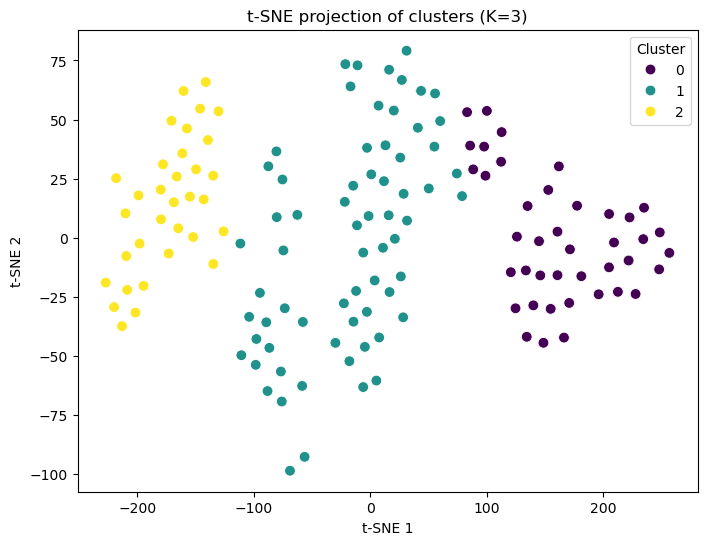

In [43]:
# --- Fit final model on elbow_k and report cluster counts + t-SNE viz ---
final_k = elbow_k
km_final = KMeans(n_clusters=final_k, init='random', n_init=20, random_state=9001)
km_final.fit(dfs)
final_labels = km_final.labels_

unique, counts = np.unique(final_labels, return_counts=True)
print(f"\nFinal chosen K={final_k} cluster counts: {dict(zip(unique, counts))}")
print(f"Final inertia: {km_final.inertia_:.6f}")
print(f"Final silhouette: {silhouette_score(dfs, final_labels):.6f}")

# t-SNE visualize (run once)
tsne = TSNE(n_components=2, random_state=9001, init='pca', learning_rate='auto')
dfs_tsne = tsne.fit_transform(dfs)
plt.figure(figsize=(8,6))
sns.scatterplot(x=dfs_tsne[:,0], y=dfs_tsne[:,1], hue=final_labels, palette='viridis', s=60, legend='full')
plt.title(f"t-SNE projection of clusters (K={final_k})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title='Cluster')
plt.show()


Final chosen K=4 cluster counts: {np.int32(0): np.int64(15), np.int32(1): np.int64(41), np.int32(2): np.int64(88), np.int32(3): np.int64(61)}
Final inertia: 174.141190
Final silhouette: 0.433666


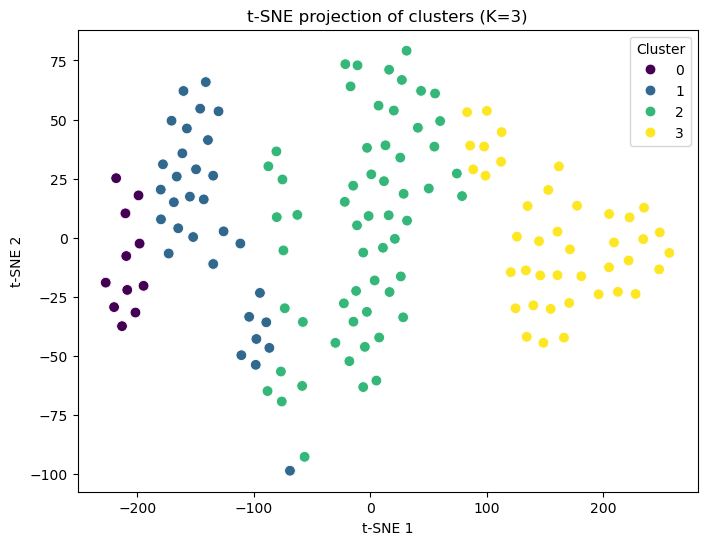

In [44]:
# --- Fit final model on K=4 and report cluster counts + t-SNE viz ---
check_k = 4
km_final = KMeans(n_clusters=check_k, init='random', n_init=20, random_state=9001)
km_final.fit(dfs)
final_labels = km_final.labels_

unique, counts = np.unique(final_labels, return_counts=True)
print(f"\nFinal chosen K={check_k} cluster counts: {dict(zip(unique, counts))}")
print(f"Final inertia: {km_final.inertia_:.6f}")
print(f"Final silhouette: {silhouette_score(dfs, final_labels):.6f}")

# t-SNE visualize (run once)
tsne = TSNE(n_components=2, random_state=9001, init='pca', learning_rate='auto')
dfs_tsne = tsne.fit_transform(dfs)
plt.figure(figsize=(8,6))
sns.scatterplot(x=dfs_tsne[:,0], y=dfs_tsne[:,1], hue=final_labels, palette='viridis', s=60, legend='full')
plt.title(f"t-SNE projection of clusters (K={final_k})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title='Cluster')
plt.show()

----

**Q1. Which value of K yeilded highest average silhoutte score?**
- K=2
- K=3
- K=4
- K=5

**Answer: K=2**

| **K** | **Inertia (↓ better)** | **Silhouette (↑ better)** |
| :---: | :--------------------: | :-----------------------: |
|   2   |       385.230909       |      **0.470819** 🏆      |
|   3   |       234.453666       |          0.453655         |
|   4   |       174.141190       |          0.433666         |
|   5   |       133.708340       |          0.420071         |
|   6   |       111.621291       |          0.414808         |


**Q2. Based on intertia (WCSS) values across K in (2,3,4,5,6), where is the most prominant elbow (largest drop in intertia across the k values)?**
- K=2
- K=3
- K=4
- K=5

**Answer: K=3**



**Q3. For K=2, what are the cluster sizes (counts)? Choose the closest**
- 60 and 145
- 100 and 105
- 75 and 130
- 85 and 120

**Answer: 85 and 120**

**Q4. Why is feature scaling important while performing k-means clustering?**
- a. It prevents overfitting by reducing model complexity
- b. It ensures distance calculations are not dominated by variables with large numeric ranges
- c. It gaurantees the algorithm finds the global optimal
- d. It gaurantees faster convergence in every dataset

**Answer: b**

**Q5. Which statement best describes what makes "good" clusters in k-means clustering?**
- a. Clusters where each point is equally distant from every centroid
- b. Clusters with low within-cluster distance and high between cluster separation
- c. Clusters that contain same number of points
- d. Clusters chosen solely by the smallest inertia value regardless of K

**Answer: b**
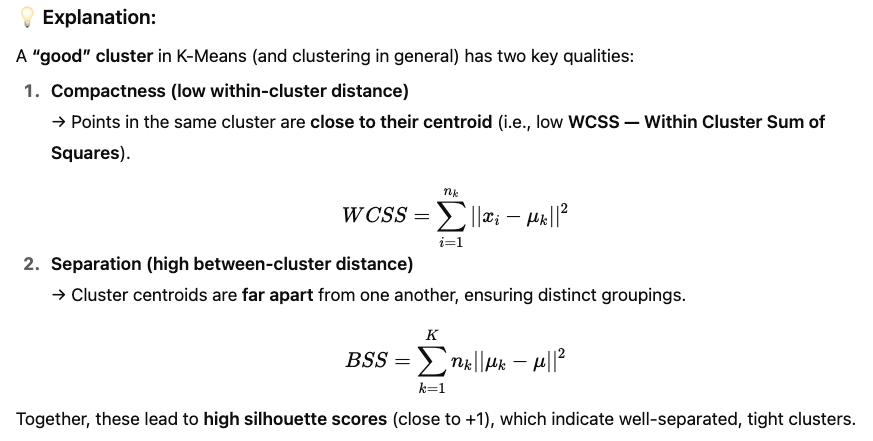